In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
#load data as dataframe with Pandas
df_train = pd.read_csv("test_data_scientist/train.csv")
df_test = pd.read_csv("test_data_scientist/test.csv")
df_bu_feat = pd.read_csv("test_data_scientist/bu_feat.csv")

In [3]:
#convert "day_id" columns into a datetime column 
df_train["day_id"] = pd.to_datetime(df_train["day_id"], format="%Y-%m-%d")
df_test["day_id"] = pd.to_datetime(df_test["day_id"], format="%Y-%m-%d")

In [4]:
df_test["day_id"].min(),df_test["day_id"].max()

(Timestamp('2017-10-07 00:00:00'), Timestamp('2017-11-25 00:00:00'))

In [5]:
df_train.shape

(277719, 4)

In [6]:
df_train = df_train.drop_duplicates()

In [7]:
len(list(df_train["but_num_business_unit"].unique())),len(list(df_train["dpt_num_department"].unique()))

(322, 4)

In [8]:
list(df_train["dpt_num_department"].unique())

[127, 88, 73, 117]

In [9]:
# To forecast the turnover at store-department level, to be as much precise as possible, a model should be built for each
# business_unit-department, meaning 322*4=1288 models.
# It is too much. We need to find some ways to reduce this number.

<AxesSubplot:xlabel='day_id', ylabel='turnover'>

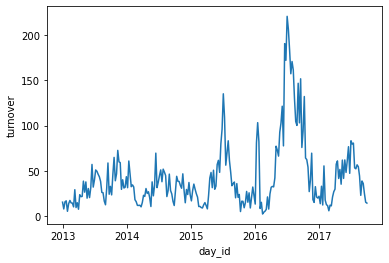

In [10]:
department = 73
business_unit = 1
df_train_viz = df_train.groupby(["day_id","dpt_num_department","but_num_business_unit"]).sum().reset_index()
filt = df_train_viz[(df_train_viz["dpt_num_department"]==department) & (df_train_viz["but_num_business_unit"]==business_unit)]
sns.lineplot(data=filt, x='day_id', y='turnover',palette="tab10")

In [11]:
df_train["year"] = df_train["day_id"].dt.year
df_train["month"] = df_train["day_id"].map(lambda x: x.strftime('%m'))
df_train["week"] = df_train["day_id"].map(lambda x: x.strftime('%W'))

In [12]:
df_train_grouped = df_train.groupby(["dpt_num_department","but_num_business_unit","year","month","week"]).sum().reset_index()
df_train_grouped = df_train_grouped[["turnover","dpt_num_department","but_num_business_unit","year","month","week"]]

In [13]:
df_train_grouped = df_train_grouped[df_train_grouped["turnover"]>=0]

In [14]:
df_train_grouped.head(2)

,turnover,dpt_num_department,but_num_business_unit,year,month,week
0,15.552508,73,1,2012,12,52
1,8.092452,73,1,2013,01,00


In [15]:
df_plot = df_train_grouped
df_plot["date"] = df_plot["year"].map(str) + df_plot["month"].map(str) + df_plot["week"].map(str)
df_plot["date"] = df_plot["date"].astype(int)

In [16]:
df_plot.head(2)

,turnover,dpt_num_department,but_num_business_unit,year,month,week,date
0,15.552508,73,1,2012,12,52,20121252
1,8.092452,73,1,2013,01,00,20130100


/home/louis/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


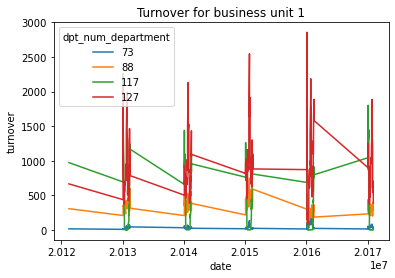

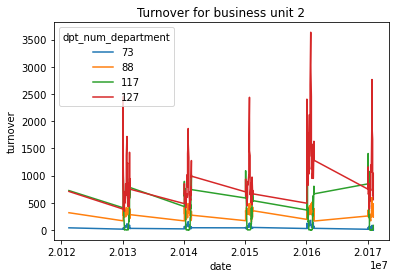

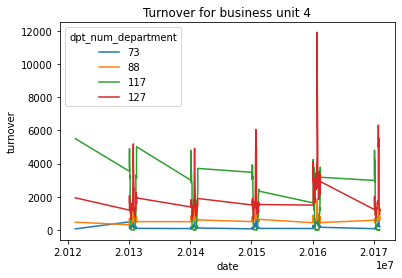

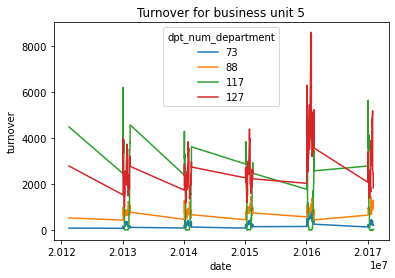

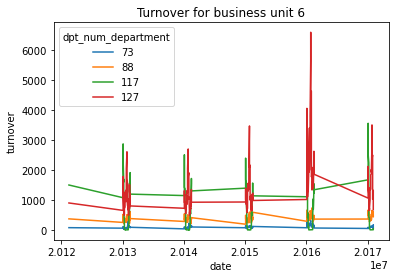

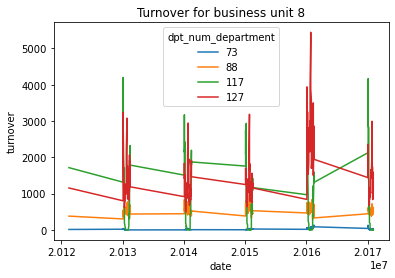

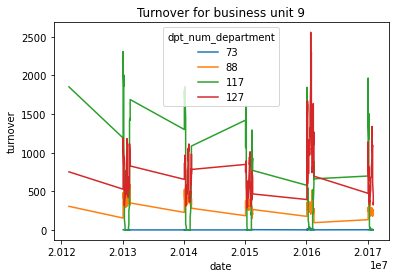

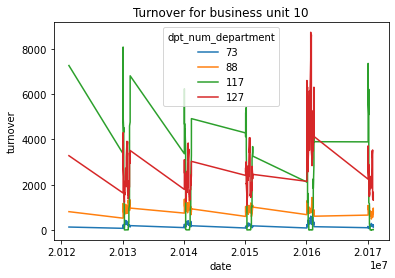

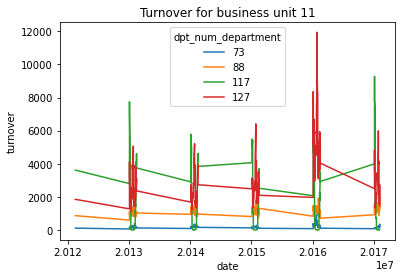

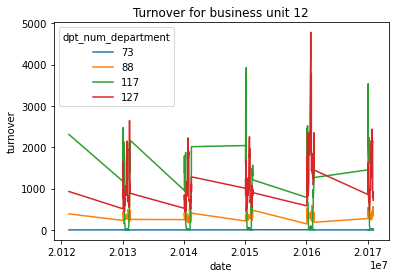

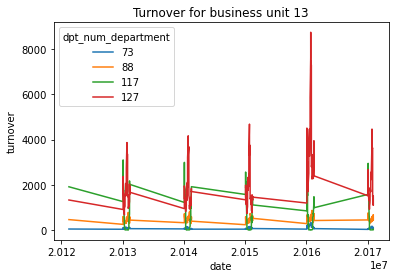

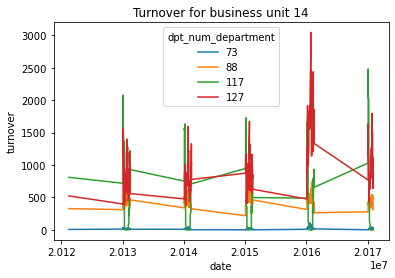

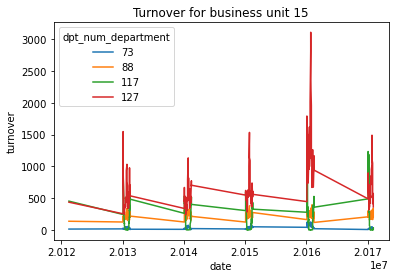

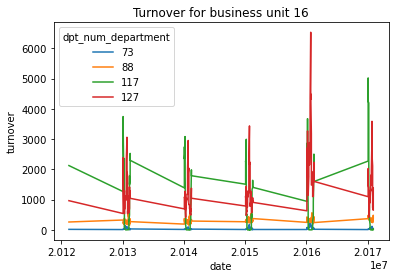

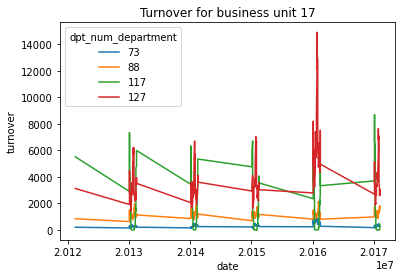

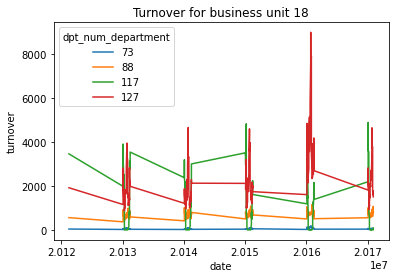

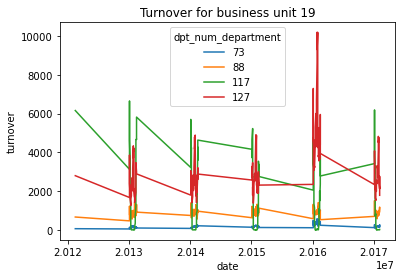

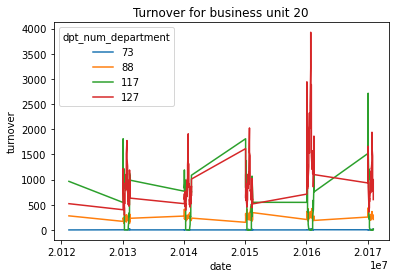

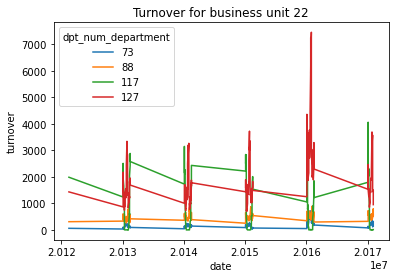

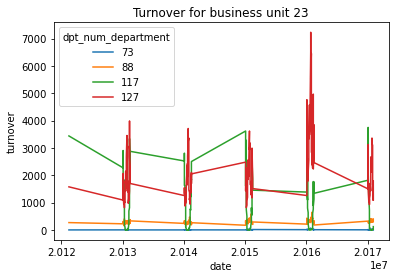

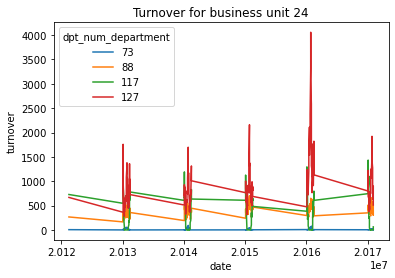

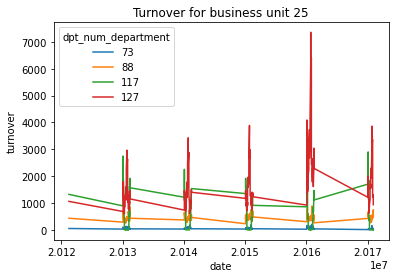

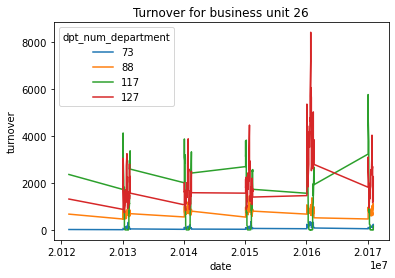

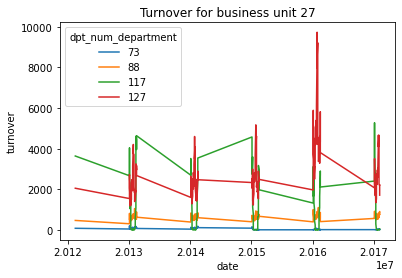

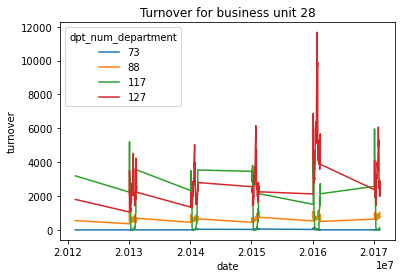

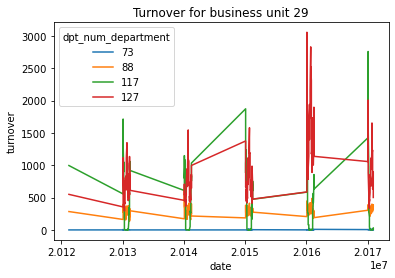

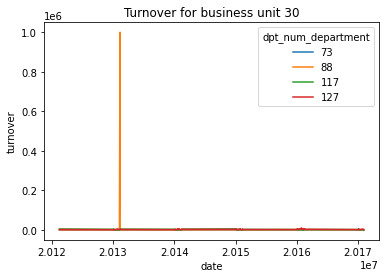

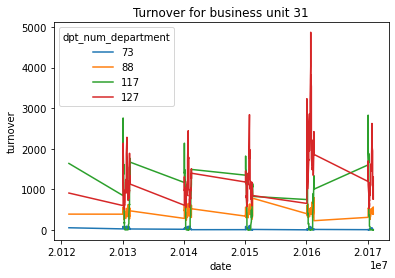

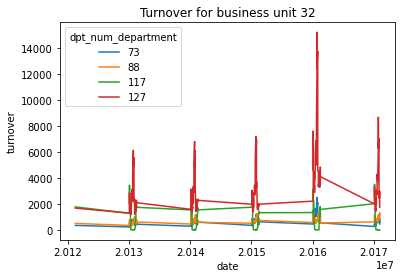

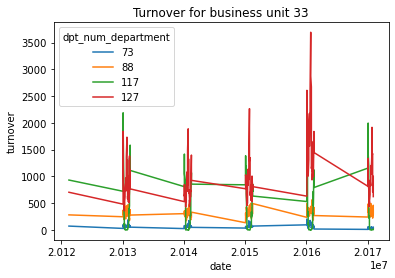

In [17]:
for i, bu in enumerate(list(df_plot["but_num_business_unit"].unique())):
    if i < 30:
        df_ventes_filt = df_plot[(df_plot["but_num_business_unit"]==bu)]
        #df_ventes_filt_grouped = df_ventes_filt.groupby(["dpt_num_department","but_num_business_unit","year","month"]).sum().reset_index()
        plt.figure(i)
        plt.title(f"Turnover for business unit {bu}")
        sns.lineplot(data=df_ventes_filt, x='date', y='turnover', hue='dpt_num_department',palette="tab10")

In [18]:
# from the graph above, we can conclude that all the departments follow a different pattern. 
# We should cannot group them immediately

In [19]:
#Idées :

#voir pour regrouper les sports ou les magasins si ils ont le même pattern

#representation des sports par magasin -> potentiellement faire forecast sur CA total du magasin 
#et on applique le pourcentage pour avoir le sport

#representation du CA du magasin dans la region ou sur le CA total 
# -> au fil du temps, toujours la même part de CA dans le CA total
# -> au fil du temps, toujours la même part de CA dans le CA region
# ->-> potentiellement faire forecast CA total et appliquer le pourcentage pour avoir le magasin

#évolution du CA du sport en fonction de la période. Some seasonalities have been observed in the first part.

In [20]:
#representation des sports par magasin

In [21]:
df_train_grouped.head(2)

,turnover,dpt_num_department,but_num_business_unit,year,month,week,date
0,15.552508,73,1,2012,12,52,20121252
1,8.092452,73,1,2013,01,00,20130100


In [22]:
df_tmp = df_train_grouped[["but_num_business_unit","dpt_num_department","turnover"]]
df_sport_magasin_year = df_tmp.groupby(["but_num_business_unit","dpt_num_department"]).sum()#.reset_index()

In [23]:
df_sport_magasin_year.head()

turnover
but_num_business_unit dpt_num_department               
1                     73                   10727.897559
                      88                   84318.204258
                      117                  75854.560702
                      127                 226964.061391
2                     73                   14738.507274

In [24]:
df_sport_magasin_year["percentage"] = df_sport_magasin_year.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2))

In [25]:
df_sport_magasin_year.head()

turnover  percentage
but_num_business_unit dpt_num_department                           
1                     73                   10727.897559        2.70
                      88                   84318.204258       21.19
                      117                  75854.560702       19.07
                      127                 226964.061391       57.05
2                     73                   14738.507274        3.64

In [26]:
df_filt = df_sport_magasin_year.reset_index()

In [27]:
df_filt = df_filt[df_filt["percentage"].isnull()!=True]

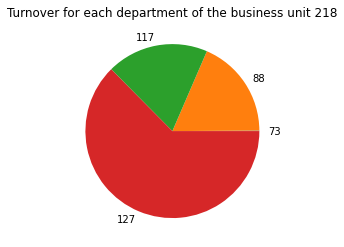

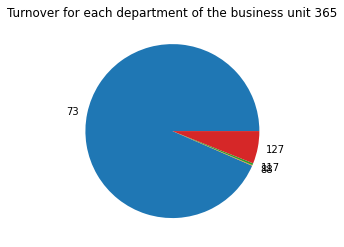

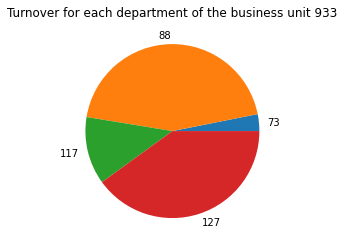

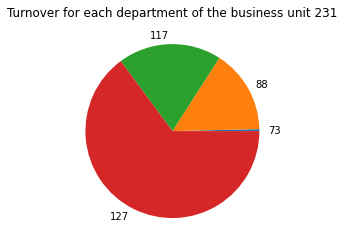

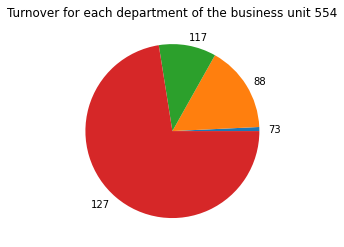

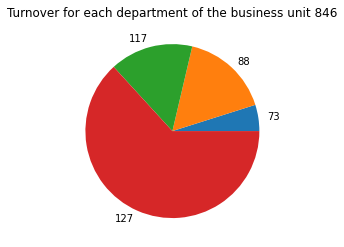

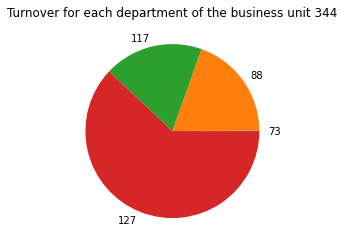

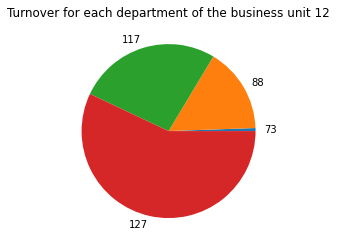

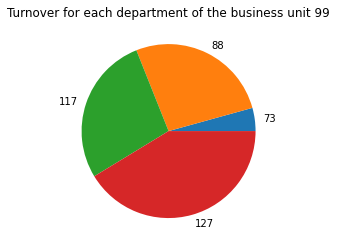

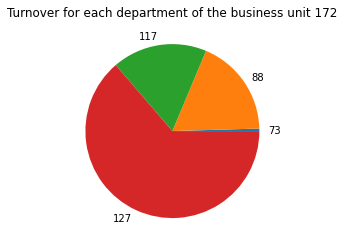

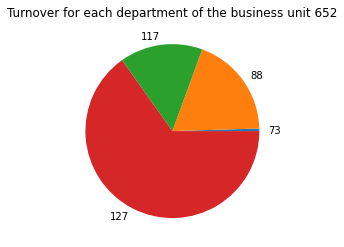

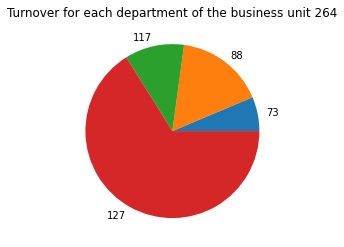

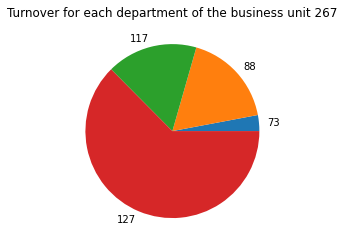

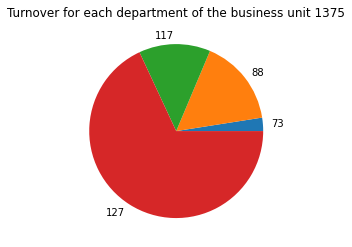

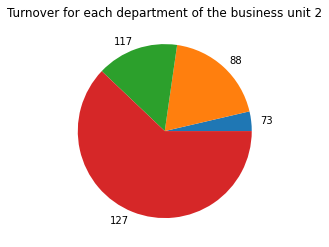

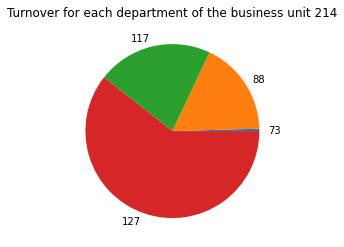

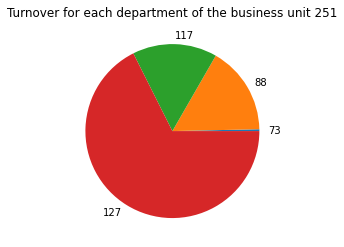

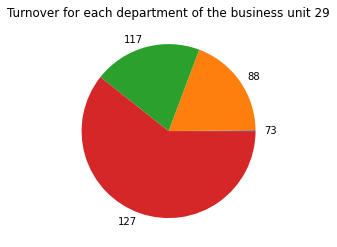

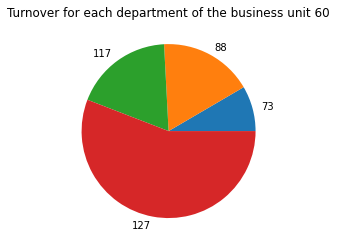

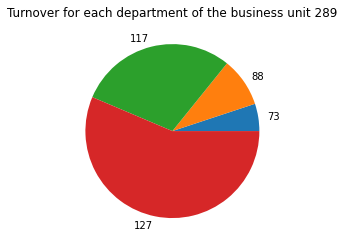

In [28]:
random_business_unit = random.sample(list(df_filt["but_num_business_unit"].unique()),20)
for i, bu in enumerate(random_business_unit):
    filt_bu = (df_filt["but_num_business_unit"]==bu)
    df_filt_plot = df_filt[filt_bu]
    plt.figure(i)
    plt.title(f"Turnover for each department of the business unit {bu}")
    plt.pie(df_filt_plot['percentage'],labels=df_filt_plot['dpt_num_department'])

In [29]:
# from the plot above, we can conclude that for all the business unit, the sport representation of each 
# department in the yearly turnover of the business units is very similar.
# It means that the forecast of the global turnover can be made and then the percentage of representation of each 
# department will be applied.

In [30]:
# find the percentage of each department

In [31]:
df_filt.head(2)

,but_num_business_unit,dpt_num_department,turnover,percentage
0,1,73,10727.897559,2.70
1,1,88,84318.204258,21.19


In [32]:
for dep in list(df_filt["dpt_num_department"].unique()):
    filt_dep = df_filt["dpt_num_department"]==dep
    df_dep = df_filt[filt_dep]
    print(f'Department {dep} : percentage representation mean : {df_dep["percentage"].mean()}')

Department 73 : percentage representation mean : 3.7614873417721517
Department 88 : percentage representation mean : 17.27596875
Department 117 : percentage representation mean : 17.056952380952378
Department 127 : percentage representation mean : 62.807917981072556


In [33]:
# étude du CA de chaque magasin en fonction du CA total au fil du temps

In [34]:
df_turnover_bu = df_train_grouped[["but_num_business_unit","turnover","year"]].groupby(["year","but_num_business_unit"]).sum()

In [35]:
df_turnover_bu.head()

turnover
year but_num_business_unit             
2012 1                      1961.070225
     2                      1785.872047
     4                      7960.734357
     5                      7856.492573
     6                      2843.629894

In [36]:
#calcul representation CA magasin en fonction du CA total sur l'année
df_turnover_bu_perc = df_turnover_bu
df_turnover_bu_perc["percentage"] = df_turnover_bu_perc.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2))
df_turnover_bu_perc = df_turnover_bu_perc.reset_index()

In [37]:
df_turnover_bu_perc.head(2)

,year,but_num_business_unit,turnover,percentage
0,2012,1,1961.070225,0.26
1,2012,2,1785.872047,0.23


In [38]:
df_turnover_bu_perc_std = df_turnover_bu_perc[["but_num_business_unit","percentage"]].groupby(["but_num_business_unit"]).std()
df_turnover_bu_perc_std.rename(columns={'percentage':'std_percentage'},inplace=True)
df_turnover_bu_perc_std = df_turnover_bu_perc_std.reset_index()

In [39]:
df_turnover_bu_perc_std

,but_num_business_unit,std_percentage
0,1,0.056451
1,2,0.013784
2,4,0.168849
3,5,0.097929
4,6,0.017224
...,...,...
317,1876,NaN
318,1881,NaN
319,1882,NaN
320,1883,NaN


In [40]:
# for some business unit, we have NaN std. 

In [41]:
bu_nan = list(df_turnover_bu_perc_std[df_turnover_bu_perc_std["std_percentage"].isnull()]["but_num_business_unit"])

In [42]:
df_t = df_turnover_bu.reset_index()
df_t[df_t["but_num_business_unit"].isin(bu_nan)].head()

,year,but_num_business_unit,turnover,percentage
1698,2017,1607,20352.977338,0.09
1699,2017,1608,38103.403663,0.16
1700,2017,1609,32667.526808,0.14
1702,2017,1616,16503.107071,0.07
1704,2017,1869,17729.073768,0.07


In [43]:
# the nan std comes from business units that exist only since 2017.

In [44]:
from matplotlib import pyplot

<AxesSubplot:xlabel='but_num_business_unit', ylabel='std_percentage'>

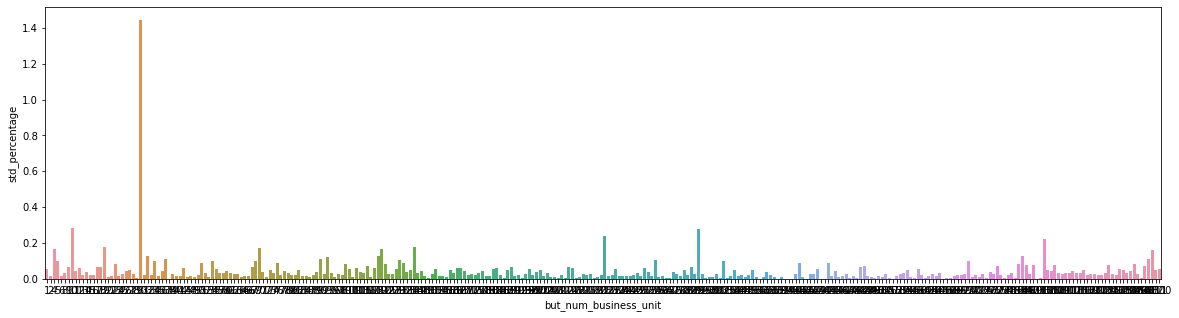

In [45]:
df_ = df_turnover_bu_perc_std[df_turnover_bu_perc_std["std_percentage"].notnull()]
fig, ax = pyplot.subplots(figsize=(20,5))
sns.barplot(ax=ax,data=df_,x="but_num_business_unit",y="std_percentage")

In [46]:
df_turnover_bu_perc_std[df_turnover_bu_perc_std["std_percentage"]>0.2]

,but_num_business_unit,std_percentage
7,10,0.285564
26,30,1.443533
155,232,0.240887
181,292,0.275880
277,1067,0.223010


In [47]:
2*df_turnover_bu_perc_std["std_percentage"].max()

2.8870654074105535

In [48]:
# au fil du temps, le pourcentage de CA du business unit par rapport au CA de tous les business unit varie au maximum de 3%.

# on peut donc considérer que la prédiction du CA du business unit pourra être calculer grâce à la prédiction du CA 
# de l'ensemble des business unit en appliquant le pourcentage de représentation du business unit.

In [49]:
#pourcentages à appliquer
df_mean_turnover_bu_perc = df_turnover_bu_perc.groupby("but_num_business_unit").mean().reset_index()
df_mean_turnover_bu_perc[["but_num_business_unit","percentage"]]

,but_num_business_unit,percentage
0,1,0.266667
1,2,0.255000
2,4,0.715000
3,5,0.835000
4,6,0.391667
...,...,...
317,1876,0.030000
318,1881,0.010000
319,1882,0.000000
320,1883,0.010000


In [50]:
#analyse turnover for the different departments along the time

In [51]:
df_turn_dep = df_train[["day_id","dpt_num_department","turnover"]]

<Figure size 432x288 with 0 Axes>

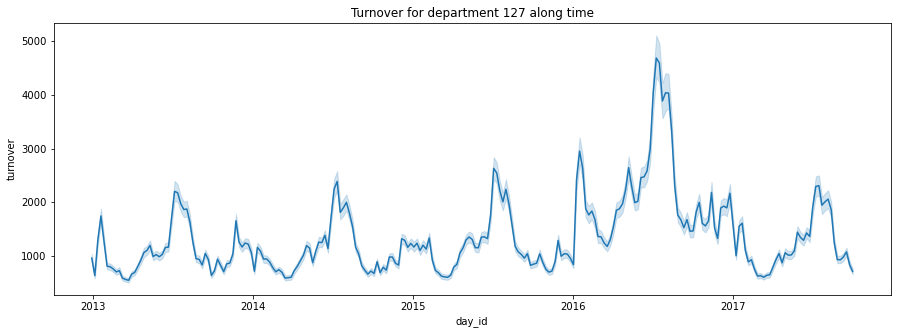

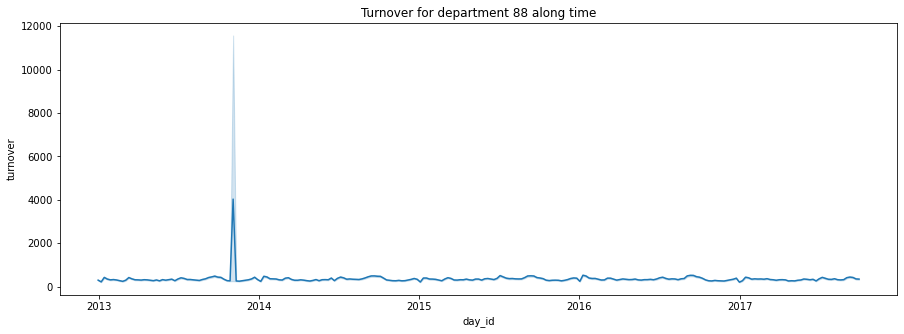

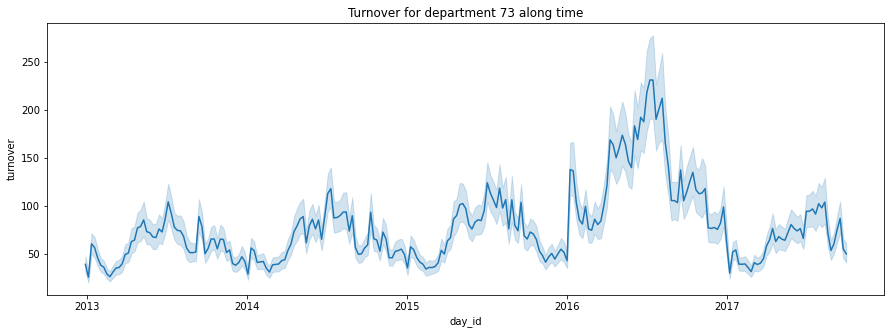

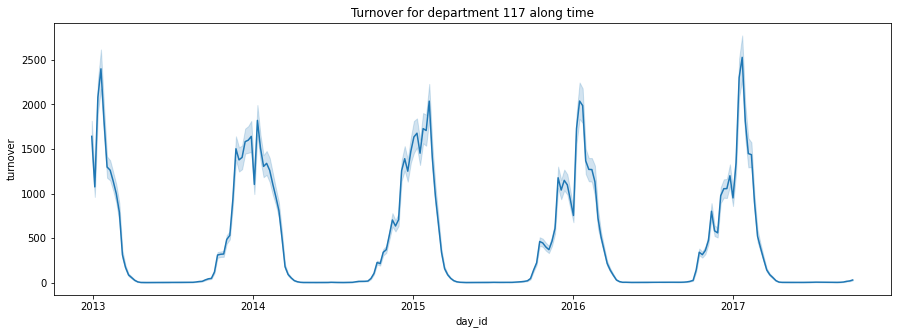

In [52]:
for i, dep in enumerate(list(df_turn_dep["dpt_num_department"].unique())):
    df_turn_dep_filt = df_turn_dep[(df_turn_dep["dpt_num_department"]==dep)]
    plt.figure(i)
    fig, ax = pyplot.subplots(figsize=(15,5))
    plt.title(f"Turnover for department {dep} along time")
    sns.lineplot(ax=ax,data=df_turn_dep_filt, x='day_id', y='turnover',palette="tab10")

In [53]:
# from these plots, we can definitely seen some beautiful seasonalities.

In [54]:
# add week feature to be able to make precise groups
df_turn_dep["week"] = df_turn_dep["day_id"].dt.isocalendar().week

/home/louis/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
#percentage turnover by department by week
df_turn_dep_gr = df_turn_dep.groupby(["dpt_num_department","week"]).sum()

In [56]:
df_turn_dep_gr["percentage"] = df_turn_dep_gr.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2))
df_turn_dep_gr

turnover  percentage
dpt_num_department week                          
73                 1     6.984738e+04        1.29
                   2     9.805009e+04        1.81
                   3     8.744827e+04        1.61
                   4     6.993676e+04        1.29
                   5     6.559926e+04        1.21
...                               ...         ...
127                49    1.524267e+06        1.60
                   50    1.539225e+06        1.62
                   51    1.580335e+06        1.66
                   52    1.608898e+06        1.69
                   53    2.292660e+05        0.24

[212 rows x 2 columns]

In [57]:
df_perc_dep_week = df_turn_dep_gr.reset_index()[["dpt_num_department","week","percentage"]]
df_perc_dep_week.head()

,dpt_num_department,week,percentage
0,73,1,1.29
1,73,2,1.81
2,73,3,1.61
3,73,4,1.29
4,73,5,1.21


In [58]:
# We can now work on the global turnover forecast

In [60]:
df_forecast_turnover = df_train[["day_id","turnover"]].groupby("day_id").sum().reset_index()
df_forecast_turnover.head(2)

,day_id,turnover
0,2012-12-29,760549.928211
1,2013-01-05,506344.523372


<AxesSubplot:title={'center':'Turnover along time'}, xlabel='day_id', ylabel='turnover'>

<Figure size 432x288 with 0 Axes>

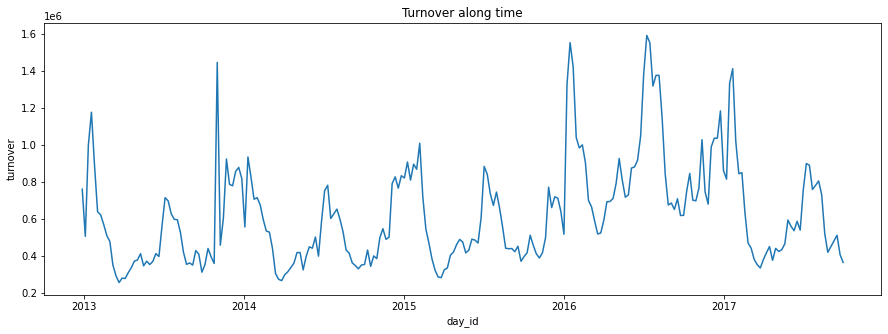

In [61]:
plt.figure(i)
fig, ax = pyplot.subplots(figsize=(15,5))
plt.title(f"Turnover along time")
sns.lineplot(ax=ax,data=df_forecast_turnover, x='day_id', y='turnover',palette="tab10")

In [70]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [74]:
#preparing data for the model
df_forecast_turnover = df_forecast_turnover.rename(columns={"day_id":"ds","turnover":"y"})

In [75]:
m = Prophet()
m.fit(df_forecast_turnover)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [77]:
future = m.make_future_dataframe(periods=60)

In [78]:
forecast = m.predict(future)

In [81]:
forecast[['ds', 'yhat']].head()

,ds,yhat
0,2012-12-29,641784.764801
1,2013-01-05,747691.738867
2,2013-01-12,886970.446557
3,2013-01-19,953251.608874
4,2013-01-26,897867.208501


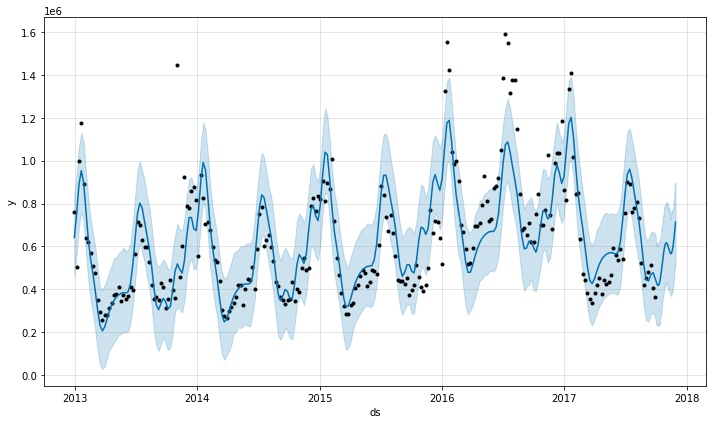

In [82]:
fig1 = m.plot(forecast)

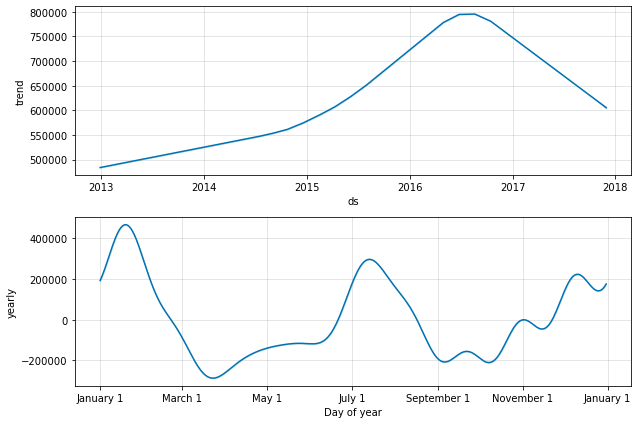

In [83]:
fig2 = m.plot_components(forecast)